In [1]:
import asyncio
import collections
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from docx import Document
from rpy2.robjects import r, pandas2ri

import sys
sys.path.append("../")

import importlib
import llm_models
importlib.reload(llm_models)

from llm_models.utils import setup_transmission_chain
from llm_models.tasks import TaskFactory
from llm_models.enums import TaskType, AzureOpenAIModelType
from llm_models.node import Node
from llm_models.openai_model import AzureOpenAIModel

study_data = Path("../llm_models/study-data/").resolve()


SOCIAL_TYPE = ['Social', 'Goss'] # Social non-gossip and Social gossip
NON_SOCIAL_TYPE = ['Ind', 'Phys'] # social-non-gossip and non-social-individual

SOCIAL = "social"
NON_SOCIAL = "non_social"
lmer_levels = "c(" + f'"{NON_SOCIAL}", "{SOCIAL}"' + ")"

LABEL_COLORS = [(SOCIAL, 'orange'), (NON_SOCIAL, 'gray')]
LINESTYLES = ["-", ":", "--"]
EXP = ['GPT/HumanEval', 'GPT/GPTEval', 'GPT/GPTEval(New)']

%load_ext autoreload
%autoreload 2

### Helper functions

In [2]:
def convert_annotations_to_proportions(results):
    """Converts annotations to final data for lmer and plotting.
    IMPORTANT: ADJUST ACCORDING TO THE TASK.
    """
    data = []
    for col in results.columns:
        if col == "original":
            continue
    
        chain_id = int(col[4])
        step_id = int(col[-1])
    
        social_prop = 1. * results.loc[SOCIAL_TYPE, col].sum() / total_social
        non_social_prop = 1. * results.loc[NON_SOCIAL_TYPE, col].sum() / total_non_social
    
        x = (chain_id, step_id, social_prop, SOCIAL)
        data.append(x)
    
        x = (chain_id, step_id, non_social_prop, NON_SOCIAL)
        data.append(x)
    
    data = pd.DataFrame(data, columns=["chain_id", "chain_step", "proportion", "content"])
    return data


def lmer(data, str_levels=None):
    """Performs LMER."""
    pandas2ri.activate() 

    # Load the lme4 library in R
    r('library(lme4)')
    r('library(lmerTest)')
    
    # Convert the DataFrame to an R data.frame
    rdf = pandas2ri.py2rpy(data)
    
    # Fit the model in R
    r.assign('rdf', rdf)
    if str_levels is None:
        levels = data['content'].unique()
        str_levels = "c(" + ",".join([f'"{cat}"' for cat in levels]) +  ")"

    r(f'rdf$content <- factor(rdf$content, levels = {str_levels})')
    model = r('lmer(proportion ~ content + (1|chain_step) + (1|chain_id), data=rdf)')
    
    # Print the summary
    print(r('summary')(model))


def convert_summaries_to_annotations(simulations):
    """Converts summaries to annotations in the form present in the anlaysis folder."""
    # prepare data
    analysis = exp_analysis[['Text part', 'Type']]
    for sim_id, all_nodes in enumerate(simulations):
        for generation in all_nodes:
            for node in generation:
                col = f"sim:{sim_id} gen:{node.id[0]}"
                analysis.loc[:, col] = 0
                # stripped_text = exp_analysis['Text part'].apply(lambda x:x.strip())
                for x in node.evaluation.split("\n"):
                    row = int(x)
                    analysis.loc[row, col] = 1
    
    sim_cols = analysis.columns[2:]
    results = {}
    for col in sim_cols:
        codes = analysis[analysis[col] == 1]['Type']
        results[col] = collections.Counter(codes)
    results['original'] = collections.Counter(analysis['Type'])
    results = pd.DataFrame(results)
    results = results.fillna(0)

    return results


def plot(ALL_DATA, ax):
    """Plots all the data. """
    for idx, key in enumerate(EXP):
        if key not in ALL_DATA:
            continue
        plot_data = ALL_DATA[key]
        max_gen = int(plot_data["chain_step"].max())
        for label, color in LABEL_COLORS:
            means, stds = [], []
            for gen in range(max_gen+1):
                filter = (plot_data["chain_step"] == gen) & (plot_data["content"] == label)
                means.append(plot_data.loc[filter, "proportion"].mean())
                stds.append(plot_data.loc[filter, "proportion"].std() / np.sqrt(sum(filter)))
            use_label = label if idx == 0 else None 
            alpha = 0.25 if idx > 0 else 0.75 # emphasize the first one
            ax.plot(range(max_gen + 1), means, color=color, alpha=alpha, label=use_label)
            ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=alpha, capsize=2, linewidth=1, linestyle=LINESTYLES[idx])
            ax.scatter(range(max_gen + 1), means, color=color)

    return ax

## Authors' Results

In [3]:
exp_data = pd.read_excel(str(study_data / "coding/study3.xlsx"))

# Renaming columns to fit the convention of previous notebooks
exp_data = exp_data.rename(columns={
    'Unnamed: 0': "Number",
    'Unnamed: 1': "Text part", 
    'Unnamed: 2': "Type",
    'Chain Step 1': "sim:0 gen:0",
    'Unnamed: 4': "sim:1 gen:0",
    'Unnamed: 5': "sim:2 gen:0",
    'Unnamed: 6': "sim:3 gen:0",
    'Unnamed: 7': "sim:4 gen:0",
    'Chain Step 2': "sim:0 gen:1",
    'Unnamed: 10': "sim:1 gen:1",
    'Unnamed: 11': "sim:2 gen:1",
    'Unnamed: 12': "sim:3 gen:1",
    'Unnamed: 13': "sim:4 gen:1",
    'Chain Step 3': "sim:0 gen:2",
    'Unnamed: 16': "sim:1 gen:2",
    'Unnamed: 17': "sim:2 gen:2",
    'Unnamed: 18': "sim:3 gen:2",
    'Unnamed: 19': "sim:4 gen:2"
}
)

exp_data = exp_data.drop(columns=["Number", "Unnamed: 8", "Unnamed: 14"])
exp_data = exp_data.iloc[1:]
exp_data = exp_data.fillna(0)

In [4]:
exp_data

,Text part,Type,sim:0 gen:0,sim:1 gen:0,sim:2 gen:0,sim:3 gen:0,sim:4 gen:0,sim:0 gen:1,sim:1 gen:1,sim:2 gen:1,sim:3 gen:1,sim:4 gen:1,sim:0 gen:2,sim:1 gen:2,sim:2 gen:2,sim:3 gen:2,sim:4 gen:2
1,HOT; WEATHER,Phys,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DRY; WEATHER,Phys,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,IN; SUMMER,Phys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,REMOVE; MOISTURE; SOIL,Phys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,DRY; PLANTS,Phys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,CATCH-FIRE; VEGETATION,Phys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,EASILY; CATCH-FIRE,Phys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CAUSE; FOREST-FIRES,Phys,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,FREQUENT; FOREST-FIRES,Phys,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,RELEASE; SMOKE,Phys,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
exp_analysis = exp_data

sim_cols = exp_analysis.columns[2:]
results_exp = {}
for col in sim_cols:
    codes = exp_analysis[exp_analysis[col] == 1]['Type']
    results_exp[col] = collections.Counter(codes)
results_exp['original'] = collections.Counter(exp_analysis['Type'])
results_exp = pd.DataFrame(results_exp)
results_exp = results_exp.fillna(0)

# #There are no baselines since we do not definitively know what is plot relevant and what is not.
total_social = results_exp.loc[SOCIAL_TYPE, 'original'].sum()
total_non_social = results_exp.loc[NON_SOCIAL_TYPE, 'original'].sum()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -68.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7248 -0.6591 -0.1148  0.5591  2.2416 

Random effects:
 Groups     Name        Variance Std.Dev.
 chain_id   (Intercept) 0.001198 0.03461 
 chain_step (Intercept) 0.004743 0.06887 
 Residual               0.002868 0.05355 
Number of obs: 30, groups:  chain_id, 5; chain_step, 3

Fixed effects:
              Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)    0.18810    0.04485  2.82317   4.194   0.0278 *  
contentsocial  0.32143    0.01955 22.00000  16.437 7.69e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
contentsocl -0.218



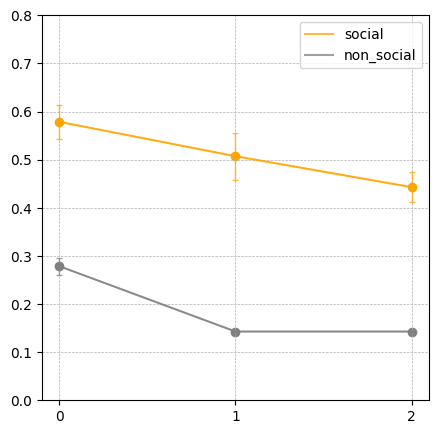

In [6]:
data_exp = convert_annotations_to_proportions(results_exp)

#lmer

lmer(data_exp, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
plot(ALL_DATA, ax)

ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 0.8)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()

## Authors' Summaries / GPT-4 Evaluation

In [7]:
summaries = []
doc = Document(str(study_data / "output/Social.docx"))
for para in doc.paragraphs:
    if para.text:
        summaries.append(para.text)

In [10]:
# define the chain
connections = [
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5

# define the api and task
llm_model_execute = None
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})

task = TaskFactory.create(TaskType.SOCIAL, llm_model_execute, llm_model_evaluate)

simulations = []
for idx in range(n_simulations):
    all_nodes = setup_transmission_chain(connections, Node, task, idx)
    all_nodes[0][0].output = summaries[idx]
    all_nodes[1][0].inputs.append(summaries[idx])
    
    all_nodes[1][0].output = summaries[idx + 5]
    all_nodes[2][0].inputs.append(summaries[idx + 5])
    
    all_nodes[2][0].output = summaries[idx + 2*5]
    simulations.append(all_nodes)

    

In [11]:
async def run_evaluation(all_nodes):
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation])

await asyncio.gather(*[run_evaluation(all_nodes) for all_nodes in simulations])

in:  1 (1, 0)
in:  3 (1, 0)
in:  2 (2, 0)
in:  2 (1, 0)
in:  4 (0, 0)
in:  2 (0, 0)
in:  0 (1, 0)
in:  3 (2, 0)
in:  0 (2, 0)
in:  0 (0, 0)
in:  1 (0, 0)
in:  3 (0, 0)
in:  4 (2, 0)
in:  4 (1, 0)
in:  1 (2, 0)


[None, None, None, None, None]

In [12]:
results = convert_summaries_to_annotations(simulations)
data = convert_annotations_to_proportions(results)

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_4718/839582966.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_4718/839582966.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_4718/839582966.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -30.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3870 -0.7014 -0.2390  0.9382  1.8425 

Random effects:
 Groups     Name        Variance  Std.Dev.
 chain_id   (Intercept) 0.0006761 0.0260  
 chain_step (Intercept) 0.0000000 0.0000  
 Residual               0.0158624 0.1259  
Number of obs: 30, groups:  chain_id, 5; chain_step, 3

Fixed effects:
              Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)    0.27619    0.03454 11.67350   7.997 4.50e-06 ***
contentsocial  0.33095    0.04599 24.00000   7.196 1.95e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
contentsocl -0.666
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')




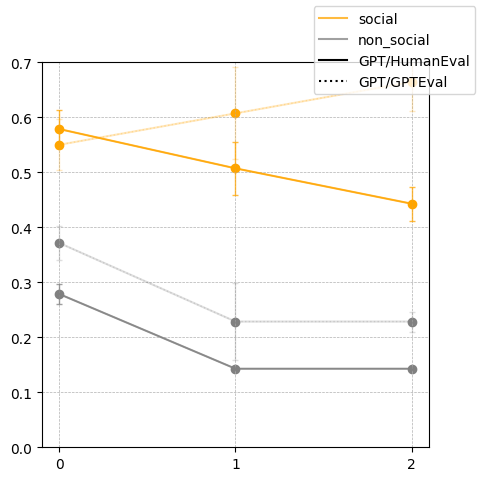

In [13]:
#lmer
lmer(data, lmer_levels)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

ALL_DATA = {}
ALL_DATA[EXP[0]] = data_exp
ALL_DATA[EXP[1]] = data
plot(ALL_DATA, ax)


ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 0.7)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
legends = []
extra_labels = []
for idx, key in enumerate(EXP):
    if key not in ALL_DATA:
        continue
    legends.append(plt.Line2D([0], [0], color='black', linestyle=LINESTYLES[idx], label=key))
    extra_labels.append(key)

handles, labels = ax.get_legend_handles_labels()

handles.extend(legends)
labels.extend(extra_labels)

# Create the legend with the combined handles and labels
fig.legend(handles, labels)

## New Summaries / GPT-4 Evaluation

In [23]:
# define the api and task
llm_model_execute = AzureOpenAIModel(AzureOpenAIModelType.GPT_3_5_TURBO, {})
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})

task = TaskFactory.create(TaskType.SOCIAL, llm_model_execute, llm_model_evaluate)

# define simulations asynchornously
async def run_simulation(connecitons, task, sim_idx):
    all_nodes = setup_transmission_chain(connections, Node, task, sim_idx)
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation ])
    return all_nodes

# define the chain
connections = [
    [[0]],
    [[0]],
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5
completed = [run_simulation(connections, task, idx) for idx in range(n_simulations)]
simulations = await asyncio.gather(*completed)

for i, all_nodes in enumerate(simulations):
    print(f"Simulation {i + 1} completed.")

sent output to  [Sim:4 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:1 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:2 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:3 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
sent output to  [Sim:4 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:0 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:4 ID:(3, 0)	Incoming nodes: [(2, 0)]	Outgoing nodes: [(4, 0)]]
sent output to  [Sim:1 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:3 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:2 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
sent output to  [Sim:4 ID:(4, 0)	Incoming nodes: [(3, 0)]	Outgoing nodes: []

In [24]:
results = convert_summaries_to_annotations(simulations)
data2 = convert_annotations_to_proportions(results)

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_4718/839582966.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_4718/839582966.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_4718/839582966.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -54.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.51992 -0.52800  0.02015  0.65969  1.96255 

Random effects:
 Groups     Name        Variance  Std.Dev. 
 chain_step (Intercept) 4.516e-12 2.125e-06
 chain_id   (Intercept) 6.735e-03 8.207e-02
 Residual               1.428e-02 1.195e-01
Number of obs: 50, groups:  chain_step, 5; chain_id, 5

Fixed effects:
                  Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)         0.5014     0.0438  5.5068  11.448 4.77e-05 ***
contentnon_social  -0.3100     0.0338 44.0000  -9.171 9.00e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cntntnn_scl -0.386
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('is

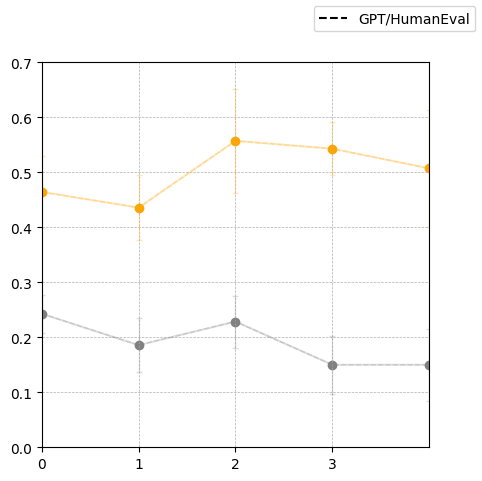

In [26]:
#lmer
lmer(data2)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)


ALL_DATA = {}
# ALL_DATA[EXP[0]] = data_exp
# ALL_DATA[EXP[1]] = data
ALL_DATA[EXP[2]] = data2

plot(ALL_DATA, ax)

# minor adjustments
ax.set_xticks(range(4))
ax.set_xlim(0, 4)
ax.set_ylim(0, 0.7)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
# Add custom legend lines
legends = []
for idx, key in enumerate(EXP):
    if key not in ALL_DATA:
        continue
    legends.append(plt.Line2D([0], [0], color='black', linestyle=LINESTYLES[idx], label=key))

handles, labels = ax.get_legend_handles_labels()

handles.extend(legends)
labels.extend(EXP)

# Create the legend with the combined handles and labels
fig.legend(handles, labels)